# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 462 kB 31.9 MB/s 
  Created wheel for adapt: filename=adapt-0.4.0-py3-none-any.whl size=101264 sha256=f1044d460b897be4253ca67359754942748ccc38f75f52c7f6b1489ad6c467d3
  Stored in directory: /root/.cache/pip/wheels/47/47/61/e923985c37a7075ec75c4b16295782354b1c5dd291d47a7637
Successfully built adapt


In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_128_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_128_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_128_train3.pkl"
Source_dir_train4 = "./Images/DANN/Source/LC25000_mix_data_128_train4.pkl"
Source_dir_train5 = "./Images/DANN/Source/LC25000_mix_data_128_train5.pkl"
Source_dir_test1 = "./Images/DANN/Source/LC25000_mix_data_128_test1.pkl"
Source_dir_test2 = "./Images/DANN/Source/LC25000_mix_data_128_test2.pkl"


Target_dir_train = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_train.pkl")
Target_dir_test = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_test.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_train.pkl")
Target_cyclegan_dir_test = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_test.pkl")

In [ ]:
BATCH_SIZE = 64
CHANNELS = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCH = 5

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)
with open(os.path.abspath(Source_dir_train4), "rb") as f:
    LC25000_train4 = pickle.load(f)
with open(os.path.abspath(Source_dir_train5), "rb") as f:
    LC25000_train5 = pickle.load(f)
with open(os.path.abspath(Source_dir_test1), "rb") as f:
    LC25000_test1 = pickle.load(f)
with open(os.path.abspath(Source_dir_test2), "rb") as f:
    LC25000_test2 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] + LC25000_train4['train'] + LC25000_train5['train']
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label'],LC25000_train4['train_label'],LC25000_train5['train_label']))
LC25000_test_data = LC25000_test1['test'] + LC25000_test2['test']
LC25000_test_labels = np.concatenate((LC25000_test1['test_label'],LC25000_test2['test_label']))

In [ ]:
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)
LC25000_test_lab = tf.one_hot(LC25000_test_labels, depth=3)

In [ ]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)
LC25000_test_data = np.array(LC25000_test_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))
print("The shape of LC25000_test_data: ", np.shape(LC25000_test_data))
print("The shape of LC25000_test_labels: " ,np.shape(LC25000_test_labels))

The shape of LC25000_train_data:  (6400, 128, 128, 3)
The shape of LC25000_train_labels:  (6400,)
The shape of LC25000_test_data:  (1600, 128, 128, 3)
The shape of LC25000_test_labels:  (1600,)


In [ ]:
import gc
gc.collect()

322

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_cyclegan_dir_train), "rb") as f:
    TCGA_cyclegan_train = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test), "rb") as f:
    TCGA_cyclegan_test = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_cyclegan_train['train']
TCGA_cyclegan_train_labels = TCGA_cyclegan_train['train_label']
TCGA_cyclegan_test_data = TCGA_cyclegan_test['test']
TCGA_cyclegan_test_labels = TCGA_cyclegan_test['test_label']

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (6400, 128, 128, 3)
The shape of TCGA_cyclegan_train_labels:  (6400,)
The shape of TCGA_cyclegan_test_data:  (6400, 128, 128, 3)
The shape of TCGA_cyclegan_test_labels:  (6400,)


./Images/TCGA_patch/patch/patch_train  contains  3200  scc and  3200  aca.

./Images/TCGA_patch/patch/patch_test  contains  3200  scc and  3200  aca.

./Images/TCGA_patch/patch_cyclegan/patch_cyclegan_train  contains  3200  scc and  3200  aca.

./Images/TCGA_patch/patch_cyclegan/patch_cyclegan_test  contains  3200  scc and  3200  aca.

In [ ]:
import gc
gc.collect()

253

## Datasets Visualization

<function matplotlib.pyplot.show>

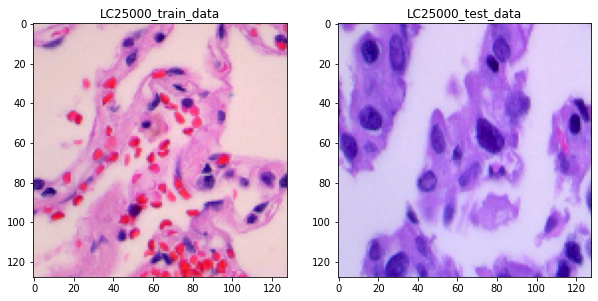

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_test_data)
img2 = array_to_img(sample2)
plt.title("LC25000_test_data")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

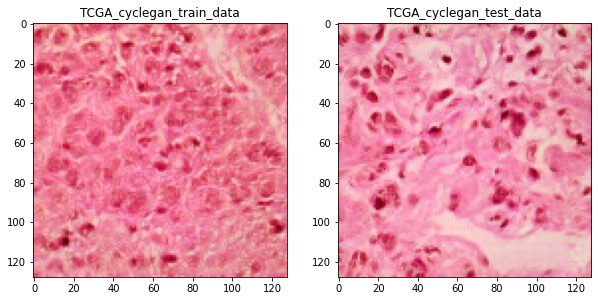

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_test_data")
plt.imshow(img2)
plt.show

In [ ]:
#LC25000_train_data, LC25000_train_labels, TCGA_cyclegan_train_data, TCGA_cyclegan_train_labels

# Domain Adaptation

## Build Model

### Feature Extractor - VGG

In [ ]:
vgg =  VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="max")

first_layer = vgg.get_layer('block4_pool')
inputs = Input(first_layer.output_shape[1:])

# for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
#     x = layer(inputs)

for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
    if layer.name == "block5_conv1":
        x = layer(inputs)
    else:
        x = layer(x)
    # x = layer(inputs)

first_blocks = Model(vgg.input, first_layer.output)
last_block = Model(inputs, x)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
def load_vgg(path="./Model/DANN_Model/vgg_last_block_128.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/vgg_last_block_128.hdf5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                           

### Extract the features 

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))

# one = OneHotEncoder(sparse=False)
# one.fit(np.array(LC25000_train_labels).reshape(-1, 1))

# LC25000_train_lab = one.transform(np.array(LC25000_train_labels).reshape(-1, 1))
# TCGA_cyclegan_train_lab = one.transform(np.array(TCGA_cyclegan_train_labels).reshape(-1, 1))

print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data (source) shape: (6400, 128, 128, 3)
TCGA_cyclegan_train_data (target) shape: (6400, 128, 128, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 5s 29ms/step - loss: 0.8640 - acc: 0.8416 - val_loss: 3.0882 - val_acc: 0.2130
Epoch 2/5
100/100 [==============================] - 2s 24ms/step - loss: 0.2166 - acc: 0.9369 - val_loss: 4.5499 - val_acc: 0.1205
Epoch 3/5
100/100 [==============================] - 2s 24ms/step - loss: 0.2099 - acc: 0.9364 - val_loss: 4.1381 - val_acc: 0.1475
Epoch 4/5
100/100 [==============================] - 2s 24ms/step - loss: 0.1695 - acc: 0.9448 - val_loss: 4.5891 - val_acc: 0.1673
Epoch 5/5
100/100 [==============================] - 2s 24ms/step - loss: 0.1732 - acc: 0.9428 - val_loss: 5.2890 - val_acc: 0.1564
Epoch 1/100
100/100 [==============================] - 5s 36ms/step - loss: 0.1562 - acc: 0.9483 - val_loss: 6.0112 - val_acc: 0.1720
Epoch 2/100
100/100 [==============================] - 3s 30ms/step - loss: 0.1520 - acc: 0.9473 - val_loss: 5.7814 - val_acc: 0.2256
Epoch 3/100
100/100 [==============================] - 3s 30ms/step - lo

### Run 2

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 5s 25ms/step - loss: 0.8808 - acc: 0.8455 - val_loss: 3.1227 - val_acc: 0.2919
Epoch 2/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2383 - acc: 0.9277 - val_loss: 4.4445 - val_acc: 0.1844
Epoch 3/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2075 - acc: 0.9314 - val_loss: 4.6059 - val_acc: 0.1477
Epoch 4/5
100/100 [==============================] - 2s 19ms/step - loss: 0.1751 - acc: 0.9431 - val_loss: 5.5006 - val_acc: 0.1150
Epoch 5/5
100/100 [==============================] - 2s 19ms/step - loss: 0.1638 - acc: 0.9434 - val_loss: 5.8703 - val_acc: 0.1211
Epoch 1/100
100/100 [==============================] - 5s 34ms/step - loss: 0.1622 - acc: 0.9520 - val_loss: 6.0110 - val_acc: 0.2037
Epoch 2/100
100/100 [==============================] - 3s 29ms/step - loss: 0.1327 - acc: 0.9538 - val_loss: 5.6912 - val_acc: 0.2455
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - lo

### Run 3

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 28ms/step - loss: 1.1012 - acc: 0.8230 - val_loss: 2.7739 - val_acc: 0.2816
Epoch 2/5
100/100 [==============================] - 2s 21ms/step - loss: 0.2507 - acc: 0.9244 - val_loss: 3.2394 - val_acc: 0.2472
Epoch 3/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1959 - acc: 0.9369 - val_loss: 3.3553 - val_acc: 0.2714
Epoch 4/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1773 - acc: 0.9397 - val_loss: 4.4511 - val_acc: 0.1872
Epoch 5/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1658 - acc: 0.9456 - val_loss: 5.3369 - val_acc: 0.1466
Epoch 1/100
100/100 [==============================] - 4s 33ms/step - loss: 0.1722 - acc: 0.9478 - val_loss: 5.5420 - val_acc: 0.1798
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1300 - acc: 0.9542 - val_loss: 6.1690 - val_acc: 0.2111
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - lo

### Run 4

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 26ms/step - loss: 0.9347 - acc: 0.8375 - val_loss: 2.7330 - val_acc: 0.2463
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2331 - acc: 0.9283 - val_loss: 3.7567 - val_acc: 0.2225
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2177 - acc: 0.9261 - val_loss: 3.6273 - val_acc: 0.2139
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.1795 - acc: 0.9386 - val_loss: 4.9371 - val_acc: 0.1355
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.1832 - acc: 0.9383 - val_loss: 5.0867 - val_acc: 0.1480
Epoch 1/100
100/100 [==============================] - 4s 32ms/step - loss: 0.1580 - acc: 0.9475 - val_loss: 4.9198 - val_acc: 0.2069
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1461 - acc: 0.9492 - val_loss: 5.9162 - val_acc: 0.1853
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - lo

### Run 5

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 24ms/step - loss: 0.7680 - acc: 0.8514 - val_loss: 3.2176 - val_acc: 0.2911
Epoch 2/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2633 - acc: 0.9234 - val_loss: 3.5674 - val_acc: 0.2230
Epoch 3/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2141 - acc: 0.9336 - val_loss: 4.1936 - val_acc: 0.1758
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.1972 - acc: 0.9341 - val_loss: 3.9268 - val_acc: 0.1934
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.1643 - acc: 0.9423 - val_loss: 4.7669 - val_acc: 0.1786
Epoch 1/100
100/100 [==============================] - 4s 32ms/step - loss: 0.1574 - acc: 0.9494 - val_loss: 4.9071 - val_acc: 0.2295
Epoch 2/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1331 - acc: 0.9533 - val_loss: 5.3973 - val_acc: 0.2531
Epoch 3/100
100/100 [==============================] - 3s 26ms/step - lo

### Result

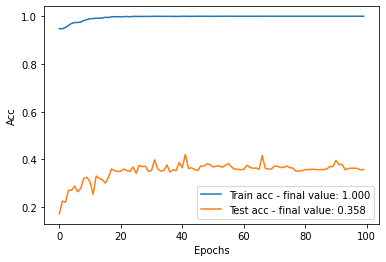

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


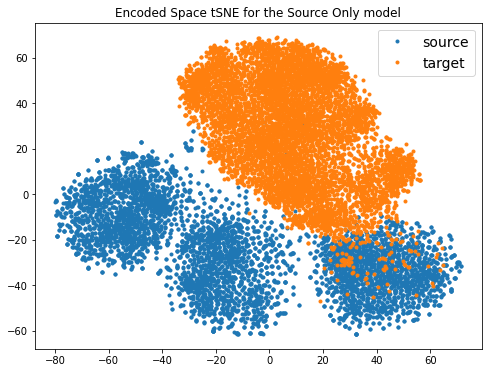

In [ ]:
LC25000_train_data_enc = finetunig.transform(LC25000_train_data_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,1.000000e+02,100.000000,100.000000,100.000000
mean,1.249290e-02,0.995934,12.783026,0.351170
std,3.227425e-02,0.010703,2.339445,0.038143
min,3.865674e-07,0.947344,5.716566,0.172031
25%,2.038704e-06,0.999062,12.257938,0.351680
50%,2.190665e-04,0.999844,13.838715,0.359609
75%,3.065461e-03,1.000000,14.280221,0.369219
max,1.561701e-01,1.000000,15.326674,0.421094


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_source_VGG_128_RMS_1e-5_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 9s 64ms/step - loss: 0.6527 - acc: 0.8455 - disc_loss: 1.9775 - val_loss: 1.8700 - val_acc: 0.2909
Epoch 2/200
100/100 [==============================] - 6s 59ms/step - loss: 0.1622 - acc: 0.9466 - disc_loss: 1.3424 - val_loss: 2.4842 - val_acc: 0.3170
Epoch 3/200
100/100 [==============================] - 6s 59ms/step - loss: 0.1395 - acc: 0.9558 - disc_loss: 1.1473 - val_loss: 2.5984 - val_acc: 0.3719
Epoch 4/200
100/100 [==============================] - 6s 59ms/step - loss: 0.1077 - acc: 0.9645 - disc_loss: 1.0678 - val_loss: 2.8828 - val_acc: 0.4011
Epoch 5/200
100/100 [==============================] - 6s 59ms/step - loss: 0.1118 - acc: 0.9650 - disc_loss: 1.1675 - val_loss: 2.8906 - val_acc: 0.4369
Epoch 6/200
100/100 [==============================] - 6s 59ms/step - loss: 0.1372 - acc: 0.9580 - disc_loss: 1.3879 - val_loss: 3.0316 - val_acc: 0.4491
Epoch 7/200
100/100 [==============================] - 6s 59ms/step - loss: 

### Run 2

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 10s 48ms/step - loss: 0.7397 - acc: 0.8314 - disc_loss: 1.9702 - val_loss: 1.7546 - val_acc: 0.3009
Epoch 2/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1764 - acc: 0.9416 - disc_loss: 1.3101 - val_loss: 2.3425 - val_acc: 0.3244
Epoch 3/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1333 - acc: 0.9573 - disc_loss: 1.1022 - val_loss: 2.8222 - val_acc: 0.3447
Epoch 4/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1051 - acc: 0.9664 - disc_loss: 1.0188 - val_loss: 3.6935 - val_acc: 0.3427
Epoch 5/200
100/100 [==============================] - 4s 43ms/step - loss: 0.0977 - acc: 0.9691 - disc_loss: 1.0476 - val_loss: 3.5983 - val_acc: 0.3831
Epoch 6/200
100/100 [==============================] - 4s 43ms/step - loss: 0.0844 - acc: 0.9770 - disc_loss: 1.1807 - val_loss: 3.7904 - val_acc: 0.3939
Epoch 7/200
100/100 [==============================] - 4s 43ms/step - loss:

### Run 3

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 9s 47ms/step - loss: 0.9828 - acc: 0.8041 - disc_loss: 2.0395 - val_loss: 1.5854 - val_acc: 0.3039
Epoch 2/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1781 - acc: 0.9377 - disc_loss: 1.3241 - val_loss: 2.6091 - val_acc: 0.2889
Epoch 3/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1461 - acc: 0.9564 - disc_loss: 1.1475 - val_loss: 2.7557 - val_acc: 0.3384
Epoch 4/200
100/100 [==============================] - 4s 41ms/step - loss: 0.0928 - acc: 0.9695 - disc_loss: 1.0571 - val_loss: 2.9980 - val_acc: 0.3656
Epoch 5/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0971 - acc: 0.9706 - disc_loss: 1.0721 - val_loss: 3.2215 - val_acc: 0.4005
Epoch 6/200
100/100 [==============================] - 4s 41ms/step - loss: 0.0946 - acc: 0.9731 - disc_loss: 1.2711 - val_loss: 3.0095 - val_acc: 0.4469
Epoch 7/200
100/100 [==============================] - 4s 41ms/step - loss: 

### Run 4

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 47ms/step - loss: 0.7421 - acc: 0.8308 - disc_loss: 1.9994 - val_loss: 1.8438 - val_acc: 0.2967
Epoch 2/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1611 - acc: 0.9470 - disc_loss: 1.3327 - val_loss: 2.8807 - val_acc: 0.3019
Epoch 3/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1403 - acc: 0.9531 - disc_loss: 1.1538 - val_loss: 2.7940 - val_acc: 0.3558
Epoch 4/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1165 - acc: 0.9647 - disc_loss: 1.0651 - val_loss: 3.4866 - val_acc: 0.3516
Epoch 5/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0847 - acc: 0.9731 - disc_loss: 1.1062 - val_loss: 3.9730 - val_acc: 0.3716
Epoch 6/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0965 - acc: 0.9720 - disc_loss: 1.3648 - val_loss: 3.6131 - val_acc: 0.4550
Epoch 7/200
100/100 [==============================] - 4s 42ms/step - loss: 

### Run 5

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 46ms/step - loss: 0.0468 - acc: 0.9925 - disc_loss: 13.5510 - val_loss: 24.5959 - val_acc: 0.4884
Epoch 2/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0522 - acc: 0.9903 - disc_loss: 13.0380 - val_loss: 32.8039 - val_acc: 0.4775
Epoch 3/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1397 - acc: 0.9795 - disc_loss: 9.2748 - val_loss: 41.1835 - val_acc: 0.4812
Epoch 4/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0715 - acc: 0.9880 - disc_loss: 5.3922 - val_loss: 45.6750 - val_acc: 0.4837
Epoch 5/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0649 - acc: 0.9894 - disc_loss: 4.1055 - val_loss: 46.5378 - val_acc: 0.4803
Epoch 6/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1517 - acc: 0.9806 - disc_loss: 2.6466 - val_loss: 44.2692 - val_acc: 0.4634
Epoch 7/200
100/100 [==============================] - 4s 42ms/step 

### Result

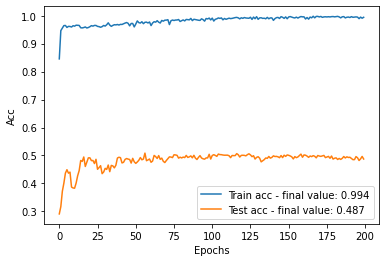

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


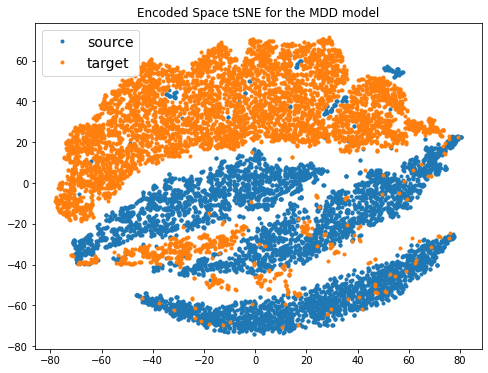

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.076931,0.982037,12.860609,12.924405,0.483341
std,0.069406,0.015949,3.094642,7.589324,0.029194
min,0.008574,0.845469,1.029027,1.870020,0.290938
25%,0.029489,0.972539,12.760678,8.171573,0.483750
50%,0.055284,0.987031,13.618690,11.511844,0.491641
75%,0.119390,0.993008,14.231716,15.725201,0.498008
max,0.652703,0.997969,15.905779,35.144272,0.508438


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD/MDD_VGG_RMS_1e-5_g1_cyclegan.csv")

In [ ]:
import gc
gc.collect()

509